<a href="https://colab.research.google.com/github/FabrizioCabreraC/Hollywood-as-recession-proof/blob/main/Hollywood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#%pip install cpi
%matplotlib inline
#%pip install scrapy
#import scrapy
#%pip install statsmodels
import statsmodels.api as sm
from statsmodels.api import OLS
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API
import matplotlib
import matplotlib.transforms as transforms

Note: you may need to restart the kernel to use updated packages.


# Background

Every time the economy dips, trade papers and the general interest press starts starts to speculate about the effects on the entertainment and movie industry. [Commentators](https://www.hollywoodreporter.com/news/general-news/how-recession-proof-is-hollywood-now-1169172/) in the business section usually seem to be optimistic pointing to an increased need for distraction in times of hardship, whereas commentators from the culture sector seem to be pessimistic, especially concerning funding for highbrow enteertainment. To our knowledge, neither side has presented sound data to support its rerasoning; both rely completely on anecdotal evidence. Turning to the academic literature is not satisfactory either, since the rather few studies provide no clear answer but raise the question whether the state of the economy is an important influencing factor at all. Therefore, we believe that this is a relevant research topic. A better understanding of the influence of economic growth on the size and nature of the demand for cinema entertainment can ultimately lead to a betteer alloaction of production resources.

# Literature Review

The literature review of cinema supply and demand suggests that economic downturns could either lead to a sober mood and drive the interest in serious genres or drive the need for distraction leading to an increased interest in feel-good or action movies (Pettijohn and Sacco 2009). However, characteristics of the movie industry suggest that economic key factors have only limited effects on supply and demand (Langford 2004). Evidence of supply and demand in three major European markets indicate that demand is unrelated to the state of the economy. In aggregate accordding to (Peterson and Anand 2004: 317-8), the demand does not instruct supply. 

# Hypothesis

The project addresses whether the state of the economy impacts the supply of and demand for cinema entertainment: 

1.   To what extent can the state of the economy explain supply of and demand for cinema entertainment?

2.   Does the state of the economy influence the genre mix of the supply and the demand?

3.   ???Do other external influences besides the state of the economy have equal or maybe higher explanatory power concerning supply of and demand for cinema entertainment?

# Dataset

To try and answer the question of how recession proof the film in industry is we collected data from three different sources.

1.   Economic data was from the Federal Reserve Economic Database through the use of the FRED API. More specifically the fredapi package was used with a custom built funtion to pull individal series. This data includes, (but may not be linited to in the final draft) real GDP, CPI, Unemployment Rate, Consumer Confidence, real GDP per capita, and the Fed Funds Rate. The time series collected for these indicator varies, but was restructed to either show monthy (if available), or quarterly data. As of this moment all the variables were merged to start in 1990, as this is when gas price was first measured, but the data many be concatinated to allow a deeper range of years for the variables that have more data.

2.   Box office data was pulled from the monthly domestic box office tables on the website BoxOffice Mojo through read.html. This data was also modfied to show quarelty sums of total box office revneue and total films released. The quartely data was then merged into the data_qrt dataframe with the economic indicators.

3.   In order to obtain the average review ratings of movies released each year further film data was taken from links to the IMDB database. More specifcially the title.basics.tsv.gz and the title.ratings.tsv.gz tables from the IMDB data sets. These two data sets have been merged together to provide the yearly average review scores for all movies released. It has not yet been merged into the data.qrt table as it can only be measured buy the year, and we are now unsure if it will need to be used in the final project.


# Visualizations

Plots to be displayed will include charts showing the relationship between certain macroeconomic indicators and the supply and demand of the film industry since the 1980s. For instance, the charts will display a time series analysis that shows the state of the economy during those years. Thus, it will be observable how well the box office did during the recessions. 

Then, we would evaluate what happened in the cinema entertainment with respect to each variable: GDP, CPI, Unemployment Rate, Consumer Confidence, GDP per capita, the Fed Funds Rate. The charts will not only show the box office performance, but they will also display the market share movements related to the film industry during the pertinent period. In such a way, it will be seen whether Hollywood was affected by recessions and/or other non-economic factors, and by how much.

# Outline


1.   Examining economic variables
2.   Examining box office data
3.   Examining IMDB datasets
4.   Comments on graphs: answering our research questions
5.   Conclusion: discussion of limitations, areas for further research

Section 1: Pulls desired economic data series from FRED API

In [282]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of a series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data sereis complied on FRED website 
    
    returns:
    --------
    dataframe: a dataframe of the FRED metric according to the data series
    given to the function
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") # my API Key,
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"} #renames value columns given lable of 0 in some cases
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

Below use the get_fred fucntion to obatin the desiresed series that will be cleaned and put into a data set.

In [283]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp
GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP
consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent
debt_income = get_fred("TDSP") #total debt service to income ratio, by quater
#debt_income
gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita
gas_prices = get_fred("GASREGCOVW") #national gas price average, by week
#gas_prices
inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year
#inflation
PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more legible and useable.

In [284]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

In [285]:
data_month = unemp.merge(consumer_sent.merge(gas_prices, on="Date", how="outer"))
#data_month.head(10)

data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head()

data_year = data_qrt.set_index("Date").resample("YS").mean()

Pulling in data from Box Office Mojo. This is the data from the film industry about the movie releases and gross revenues.

In [286]:
def get_table(url):
    '''
    Function gets the datatable requesuted from the boxoffice mojo
    url and outputs to a dataframe
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [287]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)

In [288]:

box_q1 = get_table("https://www.boxofficemojo.com/quarter/q1/?grossesOption=calendarGrosses")
box_q2 = get_table("https://www.boxofficemojo.com/quarter/q2/?grossesOption=calendarGrosses")
box_q3 = get_table("https://www.boxofficemojo.com/quarter/q3/?grossesOption=calendarGrosses")
box_q4 = get_table("https://www.boxofficemojo.com/quarter/q4/?grossesOption=calendarGrosses")

In [289]:
def reduce_table_year(df):
    jeff = df.drop(['%± LY', "Average", '#1 Release'], axis=1)
    jeff["Date"]= pd.to_datetime(jeff['Year'], format="%Y")
    return jeff

box_office_year = reduce_table_year(box_year)
box_office_year.head()

,Year,Total Gross,Releases,Date
0,2021,"$3,679,152,750",411,2021-01-01
1,2020,"$2,103,085,767",455,2020-01-01
2,2019,"$11,320,872,943",911,2019-01-01
3,2018,"$11,889,341,443",993,2018-01-01
4,2017,"$11,072,815,067",852,2017-01-01


In [290]:
def reduce_table(df, month: int):
    jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    'Genre', 'Budget', 'Running Time'], axis=1)
    jeff["month"] = month
    jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    return jeff

In [291]:
box_q1 = reduce_table(box_q1,1)
box_q2 = reduce_table(box_q2,4)
box_q3 = reduce_table(box_q3,7)
box_q4 = reduce_table(box_q4,10)

In [292]:
box_office_qrt = (pd.concat([box_q1,box_q2,box_q3,box_q4], axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office_qrt["gross"] = (box_office_qrt["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_year = box_office_year.sort_values(by=["Date"]).set_index("Date").drop(["Year"], axis=1).reset_index()
box_office_year["gross"] = (box_office_year["Total Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))
box_office_year = box_office_year.drop("Total Gross", axis=1)

<ipython-input-292-580c1e6a738d>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  box_office_qrt["gross"] = (box_office_qrt["Cumulative Gross"]
<ipython-input-292-580c1e6a738d>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  box_office_year["gross"] = (box_office_year["Total Gross"]


In [293]:
data_qrt_box = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_qrt_box["PCE"] = data_qrt_box["PCE"] * .01
data_qrt_box["gas_price"] = data_qrt_box["gas_price"]/data_qrt_box["PCE"]
data_qrt_box["gross"] = data_qrt_box["gross"]/data_qrt_box["PCE"]

#to scale gross to be measured in millions
data_qrt_box["gross"] = data_qrt_box["gross"] * .00000

# so the data starts in 1982 when the gross starts to make more sense
data_qrt_box = data_qrt_box.set_index("Date").loc["1980":"2020"]

data_qrt_box.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Cumulative Gross,Releases,Average,gross
Date,,,,,,,,,,,
1980-01-01,6.300000,63.466667,NaN,6842.024,30174.0,0.39716,10.615740,"$149,112,685",16.0,"$9,319,542",0.0
1980-04-01,7.333333,54.366667,NaN,6701.046,29470.0,0.40689,10.636900,"$398,253,502",17.0,"$23,426,676",0.0
1980-07-01,7.666667,67.766667,NaN,6693.082,29347.0,0.41641,10.406386,"$437,331,151",19.0,"$23,017,429",0.0
1980-10-01,7.400000,72.066667,NaN,6817.903,29813.0,0.42673,10.252837,"$666,317,624",24.0,"$27,763,234",0.0
1981-01-01,7.433333,68.266667,NaN,6951.495,30335.0,0.43781,10.287516,"$70,340,205",8.0,"$8,792,525",0.0


In [294]:
data_box_year = data_year.merge(box_office_year, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_box_year["PCE"] = data_box_year["PCE"] * .01
data_box_year["gas_price"] = data_box_year["gas_price"]/data_box_year["PCE"]
data_box_year["gross"] = data_box_year["gross"]/data_box_year["PCE"]
data_box_year["UNRATE"] = data_box_year["UNRATE"] * .01
#to scale gross to be measured in millions
data_box_year["gross"] = data_box_year["gross"] * .000001
# so the data starts in 1982 when the gross starts to make more sense
data_box_year = data_box_year.set_index("Date").loc["1982":"2020"]
data_box_year.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,0.097083,67.975000,NaN,6810.1200,29326.75,0.473567,10.435410,132.0,6352.537900
1983-01-01,0.096000,87.383333,NaN,7122.2905,30392.50,0.493670,10.383022,149.0,5567.348301
1984-01-01,0.075083,97.475000,NaN,7637.7040,32308.50,0.512373,10.671112,169.0,6058.671433
1985-01-01,0.071917,93.166667,NaN,7956.1695,33357.25,0.530250,11.463162,191.0,5735.936347
1986-01-01,0.070000,94.791667,NaN,8231.6635,34200.75,0.541813,11.882739,201.0,5726.692631


In [295]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t')

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [296]:
url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t')

In [297]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [298]:
df = df.query("titleType == 'movie' & isAdult == 0")
print(df.shape)
df.T.apply(lambda x: x.nunique(), axis=1)

(584479, 9)


tconst            584479
titleType              1
primaryTitle      506905
originalTitle     517606
isAdult                1
startYear            223
endYear                1
runtimeMinutes       486
genres              1376
dtype: int64

In [299]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1845
1,tt0000002,6.0,236
2,tt0000003,6.5,1603
3,tt0000004,6.0,153
4,tt0000005,6.2,2424


In [300]:
movies = df[["tconst","startYear","genres"]]
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["genres"] = movies["genres"].replace(r"\N", "null")
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before
movies = (
    movies.sort_values("startYear")
    .set_index("startYear")
    .dropna(how="any", axis=0)
)
movies = movies.loc["1982":"2020"].reset_index()
print(movies.shape)
print(movies.dtypes)

(319788, 3)
startYear    datetime64[ns]
tconst               object
genres               object
dtype: object


In [301]:
movies["genres"].value_counts()
split = movies["genres"].str.split(",", n = 3, expand = True)
print(split[0].unique()) #finally have a list of individual genres

# to remove all unwanted genres that don't seem to fit
bad_genres = [
    "Short",
    "null", 
    "Talk-Show", 
    "News", 
    "Game-Show", 
    "Reality-TV", 
    "Adult",
    "Documentary"]

for g in bad_genres:
    movies = movies[movies["genres"].str.contains(g) ==False]

movies.shape 
split.head()

['Action' 'null' 'Horror' 'Documentary' 'Comedy' 'Drama' 'Crime' 'Romance'
 'Thriller' 'Animation' 'Fantasy' 'Adventure' 'Biography' 'Musical' 'War'
 'Sport' 'Family' 'History' 'Mystery' 'Sci-Fi' 'Western' 'Adult' 'Music'
 'Reality-TV' 'News' 'Talk-Show' 'Short' 'Game-Show']


,0,1,2
0,Action,Drama,None
1,null,None,None
2,Action,Thriller,None
3,null,None,None
4,null,None,None


In [302]:
rated = pd.merge(movies, df_ratings, on="tconst", how="inner")
rated["weighted_ave"] = (rated["averageRating"] * rated["numVotes"]) 
rated.shape

(142874, 6)

In [303]:
genres = pd.DataFrame()

genres["Date"] = rated.startYear
genres["tconst"] = rated.tconst

genre_list = [
    "Action",
    "Drama",
    "Adventure",
    "Comedy",
    "War",
    "Thriller",
    "Crime",
    "Animation",
    "Horror",
    "Biography",
    "History",
    "Western",
    "Romance",
    "Fantasy",
    "Family",
    "Musical",
    "Mystery",
    "Sci-Fi",
    "Sport"
]

for g in genre_list:
    genres[g] = rated["genres"].str.contains(g)


genres = genres.replace({True:1,False:0})
genres.head()


,Date,tconst,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,...,Biography,History,Western,Romance,Fantasy,Family,Musical,Mystery,Sci-Fi,Sport
0,1982-01-01,tt0165247,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1982-01-01,tt0082278,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1982-01-01,tt0083529,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1982-01-01,tt0083521,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1982-01-01,tt0083545,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


Serious: A combination of the drama, documentary, history and biography, and thriller genres. The audience presumably watches this umbrella genre for reflection and intellectual stimulation (cognitive reception mode).

Middle: ...

Feel-good: A combination of the animation, comedies, romances, and musicals genres. The audience presumably watches this umbrella genre for distraction and for cheering up (affective/emotional reception mode).

In [304]:
genres["Act-Advent"] = genres["Action"] + genres["Adventure"]
genres["Sci-Fantasy"] = genres["Sci-Fi"] + genres["Fantasy"]
genres["Rom-Com"] = genres["Romance"] + genres["Comedy"]
genres["Hor-Thrill"] = genres["Horror"] + genres["Thriller"]
genres["Fam-Animat"] = genres["Family"] + genres["Animation"]
genres["Crime-Myst"] = genres["Crime"] + genres["Mystery"]
genres["Hist-Western"] = genres["History"] + genres["Western"] + genres["War"] + genres["Biography"]
genres["Sports-Music"] = genres["Sport"] + genres["Musical"]

genres["Serious"]= (
    genres["Horror"] + 
    genres["Drama"] +
    genres["Thriller"] +
    genres["Crime"] +
    genres["War"]
)

genres["Middle"] = (
    genres["Action"] + 
    genres["Adventure"] +
    genres["Sci-Fi"] +
    genres["Fantasy"] +
    genres["Western"] +
    genres["History"] + 
    genres["Biography"] +
    genres["Mystery"]
)

genres["Feel Good"]= (
    genres["Family"] + 
    genres["Comedy"] +
    genres["Romance"] +
    genres["Musical"] +
    genres["Animation"]
)

comb_cats = ["Drama", "Rom-Com", "Hor-Thrill", "Act-Advent", "Crime-Myst", "Sci-Fantasy", "Fam-Animat", "Hist-Western", "Sports-Music"]
comb_cats_c = ["dodgerblue", "limegreen", "tomato", "lightblue", "darkorange", "blueviolet", "gold", "crimson", "darkseagreen"]
three_cats = ["Serious", "Middle", "Feel Good"]
three_cats_c = ["tab:blue", "tab:orange", "tab:green"] 

genres_share = genres.copy()
genres.shape

(142874, 32)

In [305]:
for g in comb_cats:
    genres[g] = genres[g].replace({2:1, 3:1, 4:1})

for k in three_cats:
    genres[k] = genres[k].replace({2:1, 3:1})

genres = genres.set_index("Date").resample("YS").sum()
genres.head()


,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Sci-Fantasy,Rom-Com,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good
Date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,289,1023,139,542,44,111,175,44,134,31,...,128,681,213,150,217,113,69,1260,564,804
1983-01-01,291,1072,156,548,69,132,184,40,106,33,...,135,712,220,117,229,145,68,1315,588,827
1984-01-01,298,1074,129,572,45,150,204,35,106,29,...,145,719,227,141,245,107,64,1315,589,841
1985-01-01,334,1023,156,583,63,139,210,44,118,29,...,136,731,227,130,245,120,57,1294,611,838
1986-01-01,366,1104,160,604,60,168,238,58,141,31,...,153,776,273,152,274,125,70,1418,682,907


In [306]:
genres_pct = genres.pct_change() * 100
genres_pct.head()

,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Sci-Fantasy,Rom-Com,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good
Date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,0.692042,4.789834,12.230216,1.107011,56.818182,18.918919,5.142857,-9.090909,-20.895522,6.451613,...,5.468750,4.552129,3.286385,-22.000000,5.529954,28.318584,-1.449275,4.365079,4.255319,2.860697
1984-01-01,2.405498,0.186567,-17.307692,4.379562,-34.782609,13.636364,10.869565,-12.500000,0.000000,-12.121212,...,7.407407,0.983146,3.181818,20.512821,6.986900,-26.206897,-5.882353,0.000000,0.170068,1.692866
1985-01-01,12.080537,-4.748603,20.930233,1.923077,40.000000,-7.333333,2.941176,25.714286,11.320755,0.000000,...,-6.206897,1.668985,0.000000,-7.801418,0.000000,12.149533,-10.937500,-1.596958,3.735144,-0.356718
1986-01-01,9.580838,7.917889,2.564103,3.602058,-4.761905,20.863309,13.333333,31.818182,19.491525,6.896552,...,12.500000,6.155951,20.264317,16.923077,11.836735,4.166667,22.807018,9.582689,11.620295,8.233890


In [307]:
genres_share["Total_Movies"] = 1
genres_share["Total_Genres"] = (
    genres_share["Action"] +
    genres_share["Drama"] +
    genres_share["Adventure"] +
    genres_share["Comedy"] +
    genres_share["War"] +
    genres_share["Thriller"] +
    genres_share["Crime"] +
    genres_share["Animation"] +
    genres_share["Horror"] +
    genres_share["Biography"] +
    genres_share["History"] +
    genres_share["Western"] +
    genres_share["Romance"] +
    genres_share["Fantasy"] +
    genres_share["Family"] +
    genres_share["Musical"] +
    genres_share["Mystery"] +
    genres_share["Sci-Fi"] +
    genres_share["Sport"])

print(genres_share["Total_Genres"].unique())
genres_share.head()

genres_share = genres_share.set_index("Date").resample("YS").sum()
genres_share.head()



[2 1 3 0]


,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good,Total_Movies,Total_Genres
Date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,289,1023,139,542,44,111,175,44,134,31,...,245,156,236,125,69,1487,701,940,1847,3144
1983-01-01,291,1072,156,548,69,132,184,40,106,33,...,238,128,250,157,69,1563,739,957,1911,3274
1984-01-01,298,1074,129,572,45,150,204,35,106,29,...,256,154,263,117,64,1579,709,999,1895,3304
1985-01-01,334,1023,156,583,63,139,210,44,118,29,...,257,143,265,131,57,1553,751,1006,1882,3323
1986-01-01,366,1104,160,604,60,168,238,58,141,31,...,309,169,298,136,70,1711,817,1053,2036,3607


In [308]:

for g in genre_list:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

for g in three_cats:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

comb_cated = ["Rom-Com", "Hor-Thrill", "Act-Advent", "Crime-Myst", "Sci-Fantasy", "Fam-Animat", "Hist-Western", "Sports-Music"]

for g in comb_cated:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

genres_share.head()

,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good,Total_Movies,Total_Genres
Date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,0.091921,0.325382,0.044211,0.172392,0.013995,0.035305,0.055662,0.013995,0.042621,0.009860,...,0.077926,0.049618,0.075064,0.039758,0.021947,0.472964,0.222964,0.298982,1847,3144
1983-01-01,0.088882,0.327428,0.047648,0.167379,0.021075,0.040318,0.056200,0.012217,0.032376,0.010079,...,0.072694,0.039096,0.076359,0.047954,0.021075,0.477398,0.225718,0.292303,1911,3274
1984-01-01,0.090194,0.325061,0.039044,0.173123,0.013620,0.045400,0.061743,0.010593,0.032082,0.008777,...,0.077482,0.046610,0.079600,0.035412,0.019370,0.477906,0.214588,0.302361,1895,3304
1985-01-01,0.100512,0.307854,0.046946,0.175444,0.018959,0.041830,0.063196,0.013241,0.035510,0.008727,...,0.077340,0.043033,0.079747,0.039422,0.017153,0.467349,0.226001,0.302738,1882,3323
1986-01-01,0.101469,0.306072,0.044358,0.167452,0.016634,0.046576,0.065983,0.016080,0.039091,0.008594,...,0.085667,0.046853,0.082617,0.037704,0.019407,0.474355,0.226504,0.291932,2036,3607


In [309]:
genres_share = genres_share.reset_index()
genres_share["Date"] = genres_share["Date"].dt.year
genres_share = genres_share.set_index("Date")
genres_share.head()

,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good,Total_Movies,Total_Genres
Date,,,,,,,,,,,,,,,,,,,,,
1982,0.091921,0.325382,0.044211,0.172392,0.013995,0.035305,0.055662,0.013995,0.042621,0.009860,...,0.077926,0.049618,0.075064,0.039758,0.021947,0.472964,0.222964,0.298982,1847,3144
1983,0.088882,0.327428,0.047648,0.167379,0.021075,0.040318,0.056200,0.012217,0.032376,0.010079,...,0.072694,0.039096,0.076359,0.047954,0.021075,0.477398,0.225718,0.292303,1911,3274
1984,0.090194,0.325061,0.039044,0.173123,0.013620,0.045400,0.061743,0.010593,0.032082,0.008777,...,0.077482,0.046610,0.079600,0.035412,0.019370,0.477906,0.214588,0.302361,1895,3304
1985,0.100512,0.307854,0.046946,0.175444,0.018959,0.041830,0.063196,0.013241,0.035510,0.008727,...,0.077340,0.043033,0.079747,0.039422,0.017153,0.467349,0.226001,0.302738,1882,3323
1986,0.101469,0.306072,0.044358,0.167452,0.016634,0.046576,0.065983,0.016080,0.039091,0.008594,...,0.085667,0.046853,0.082617,0.037704,0.019407,0.474355,0.226504,0.291932,2036,3607


<AxesSubplot:xlabel='startYear'>

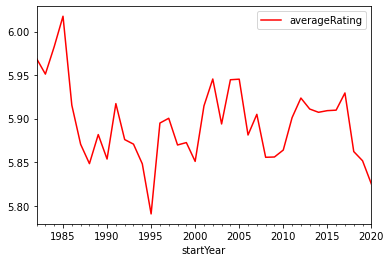

In [310]:
ave_rate = rated.groupby("startYear").mean()
ave_rate = pd.DataFrame(ave_rate).reset_index()
ave_rate.plot(x="startYear", y="averageRating", color="r")

<AxesSubplot:xlabel='startYear'>

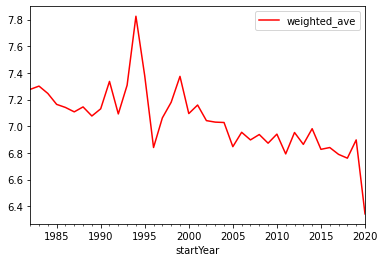

In [311]:
# weighted average rating

w_ave_rate = rated.groupby("startYear").sum()
w_ave_rate["weighted_ave"] = w_ave_rate["weighted_ave"] / w_ave_rate["numVotes"]
w_ave_rate = w_ave_rate.reset_index()
w_ave_rate.plot(x="startYear", y="weighted_ave", color="r")


# Visualization

Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
				-We got the movie gross revenues (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		2-How does it shift the respective market shares of different genres?
		3-Do other external factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.
		4-Consumer confidence increased. *Key indicator to evaluate*


The objective of this project is threefold. First, we analyze whether there is a general impact of GDP per capita, consumer sentiment, and unemployment rate on the movie industry. By analyzing the number of movies released (supply) as well as the box office revenue (demand), we can distinguish between the reaction of the industry and that of the audience. In the second step, we capture possible shifts in the market shares of different genres by analyzing genre-specific supply and demand. Judging from the literature, we expect limited and delayed effects of changes in economic indicators on supply and demand for cinema entertainment. The time lag is likely to differ for the variables. Consumer confidence and demand may change synchronously while it would take some time for distributors to adjust supply to a changed GDP. In the third step, In the third step, we analyze whether there is actually a reciprocal relation between supply and demand and introduce historic event as alternative explanation.

In [312]:
# get the data_box_year in percent change so that we can plot them in the same graph

data_box_year_pct = data_box_year.pct_change()
data_box_year_pct.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,-0.011159,0.285522,NaN,0.045839,0.036341,0.042449,-0.005020,0.128788,-0.123603
1984-01-01,-0.217882,0.115487,NaN,0.072366,0.063042,0.037885,0.027746,0.134228,0.088251
1985-01-01,-0.042175,-0.044199,NaN,0.041696,0.032460,0.034892,0.074224,0.130178,-0.053268
1986-01-01,-0.026651,0.017442,NaN,0.034626,0.025287,0.021806,0.036602,0.052356,-0.001612


In [313]:
# I think we don't use this anymore.

# data_qrt_Datex = data_qrt.set_index('Date')
# data_qrt_Datex_pct = data_qrt_Datex.pct_change()
# data_qrt_Datex_pct.head()

### US Recession Periods

Import new dataset that includes information about the US recession recessions. This is used to evaluate the movement of our explanatory variables during the recession periods. Data was cleaned to have the recession bars also in the negaative axis.

In [314]:
us_rec = get_fred("USREC") #recession indicator data
us_rec["Date"] = pd.to_datetime(us_rec["Date"])
us_rec["negative"] = us_rec["USREC"] * -1
us_rec = us_rec.set_index("Date").loc["1978":"2021"]
us_rec_scale = us_rec * 100000

### Economic variables

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0, 0.5, 'Index')

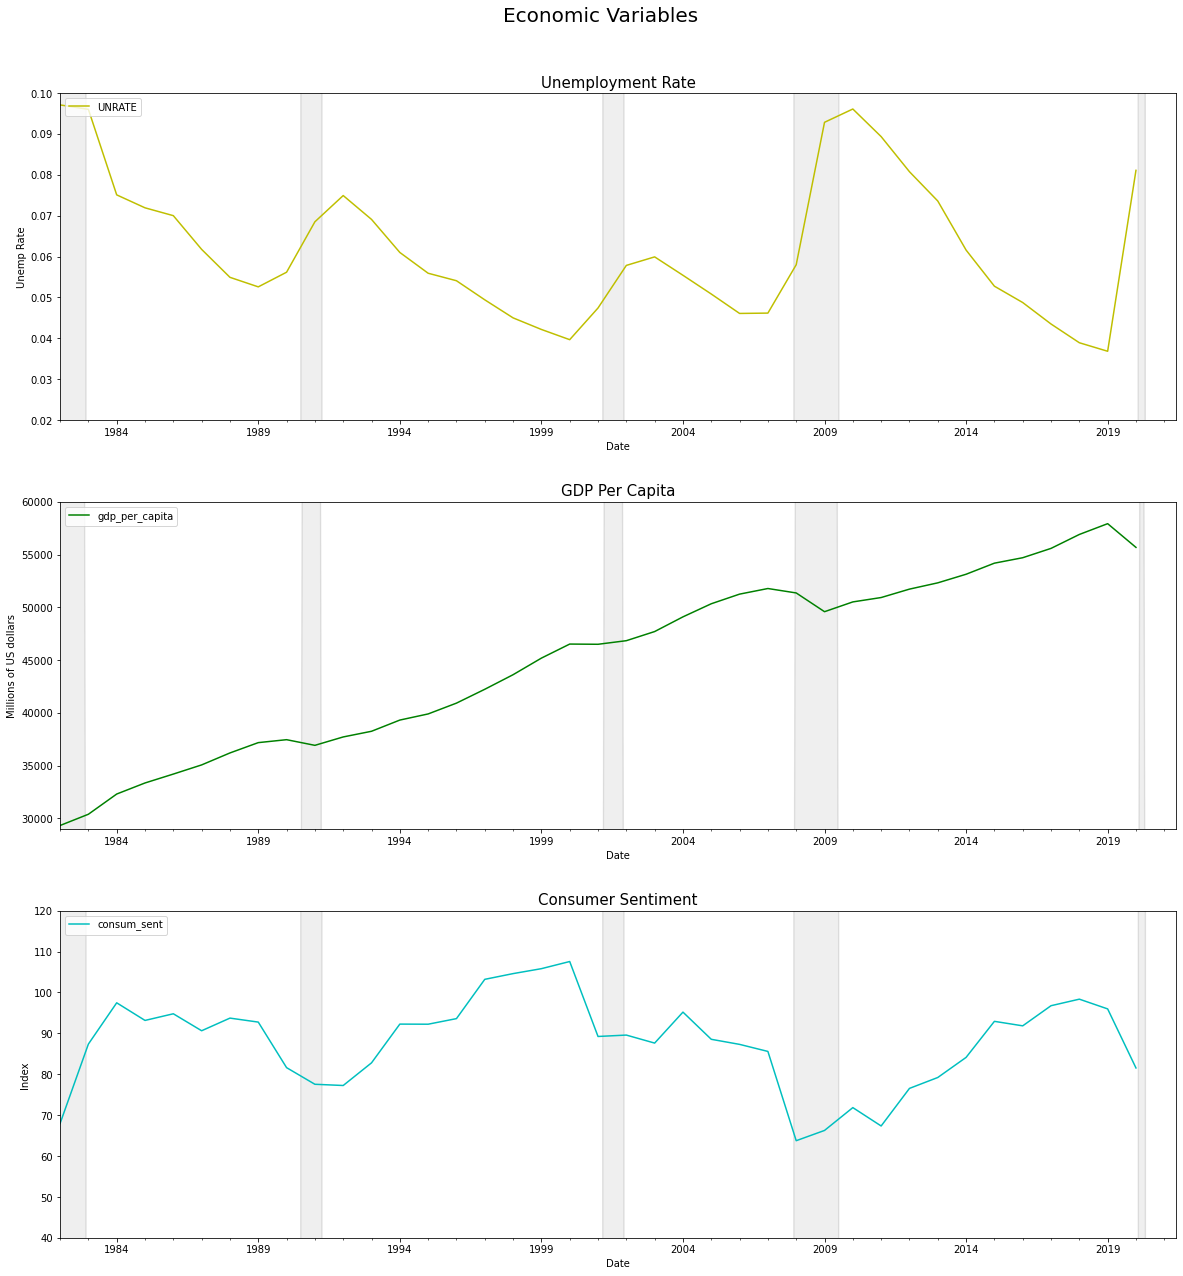

In [315]:
# Economic Variables

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year[['UNRATE']].plot(ax=axs[0], color = ('y'))
axs[0].legend(loc='upper left', ncol=3, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(0.02, 0.1)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year[['gdp_per_capita']].plot(ax=axs[1], color = ('g'))
axs[1].legend(loc='upper left', ncol=3, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(29000, 60000)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year[['consum_sent']].plot(ax=axs[2], color = ('c'))
axs[2].legend(loc='upper left', ncol=3, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(40, 120)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Sentiment", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("Unemp Rate")
axs[1].set_ylabel("Millions of US dollars")
axs[2].set_ylabel("Index")



Description of pattern of curve during recession:

The [unemployment rate](https://www.epi.org/newsroom/useful_definitions/) measures the share of workers in the labor force who do not currently have a job but are actively looking for work. 

[Gross Domestic Product](https://www.focus-economics.com/economic-indicator/gdp-per-capita) (GDP) per capita shows a country's GDP divided by its total population.

[Consumer sentiment](https://www.investopedia.com/terms/c/consumer-sentiment.asp) is a statistical measurement of the overall health of the economy as determined by consumer opinion. It takes into account people's feelings toward their current financial health, the health of the economy in the short-term, and the prospects for longer-term economic growth, and is widely considered to be a useful economic indicator.

1.   Unemployment rate: In all of the five recessions, the patteern has been that one year prior to the start of each recession period, there was an increase in the unemployment rate. Then, it took almost four years for the economy to recover in all of the five recessions. The largest and most rapid increase in unemployment rate occurred during the GFC.
2.   GDP per capita: There was an exponential increase in unemployment over time, where the GDP per capita in the US never decreasded until the last two recessions. After the GFC, it took 2 years for the GDP per capita to recover the previous level. 
3.   Consumer sentiment: The index decreased at least 12 points prior to each of the five recessions. In all the cases, households anticipated the recessions, and that can be seen by their change in behavior on average one year and six months prior to the event. One thing to notice is that the consumer sentiment level prior to the Dotcom recession was never recovered. Lower levels of confidence impy higher uncertainty in the economy.

### Economic variables and DEMAND side of the film industry


Text(2009-01-01, 7500, 'The Great Recession')

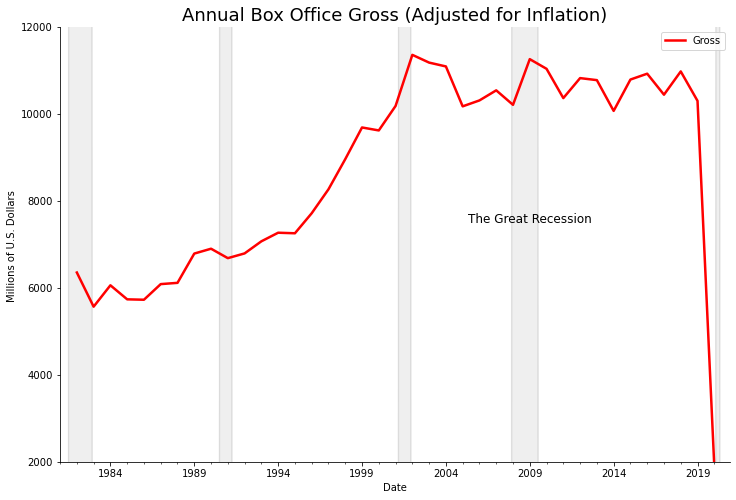

In [316]:
# Annual Box Office Gross (Adjusted for Inflation)
fig, axs = plt.subplots(figsize=(12,8))

us_rec_scale["USREC"].plot.area(ax=axs, alpha=0.12, color="gray", label=str())

data_box_year['gross'].plot(
    color = ('red'), 
    ax=axs, 
    label="Gross",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper right')
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(2000,12000)

axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.set_title(
    "Annual Box Office Gross (Adjusted for Inflation)",
    fontsize = 18)
axs.set_ylabel("Millions of U.S. Dollars ")

axs.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 7500),
    fontsize=12,
     horizontalalignment="center")

Description of curve during recessions

1.   From 1981-08-01 to 1982-11-01: There is a decrease in gross revenues from approximately 61000 to 58000 millions of US dollars. Then, the revenues stays constant until 1988, where it reaches again the pre-recessionary values. So we can say that it took almost 7 years to the movie industry to generate the same amount of revenues as in 1981. After reaching those values, the gross revenues peaked at 65000 millions of US dollars in 1990, just before entering into the next recession.
2.   From 1990-08-01 to 1991-03-01: Early in 1990 the gross revenues decreased only 1000 millions of US dollars before the second recession of our analysis started. However, gross revenues started increasing at the beginning of 1991, before the end of the second recession. Revenues increased relatively slow reaching 66000 millions of US dollars. Then 4 years after the second recession ended, in 1995, there was a rapid increase in gross revenues of the film industry. The values reached in 1999 were almost 10000 millions of US dollars.
3.   From 2001-04-01 to 2001-11-01: Those revenues continued increasing until 2002, where the revenues where 11700 millions of US dollars. Higher than ever in history. However, after those all time highs and after the Dotcom bubble burst, the was a decrease in revenues until 10000 millions of US dollars in 2008, at the beginning of the Great Recession.
4.   From 2008-01-01 to 2009-06-01: During the Great Recession, gross revenues increased until 11500 millions of US dollars, but again, just like afteer the Dotcom recession, the gross revenues decreased until approximately 10000 millions of US dollars. After that, the gross revenues stayed constant around 11200 millions of US dollars until 2019. Then From 2019 to 2020 there has been a major decrease never seen in the film industry, where gross revenues from cinema entertainment fell from 10000 to 2000 millions of US dollars.
5.   From 2020-03-01 to 2020-04-01: The gross revenues of the film industry were already 80% lower than in 2019, before the Covid recession arrived altogether with lockdowns in the US.



The variable for cumulative revenue is "gross".


/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0, 0.5, 'Percent Change')

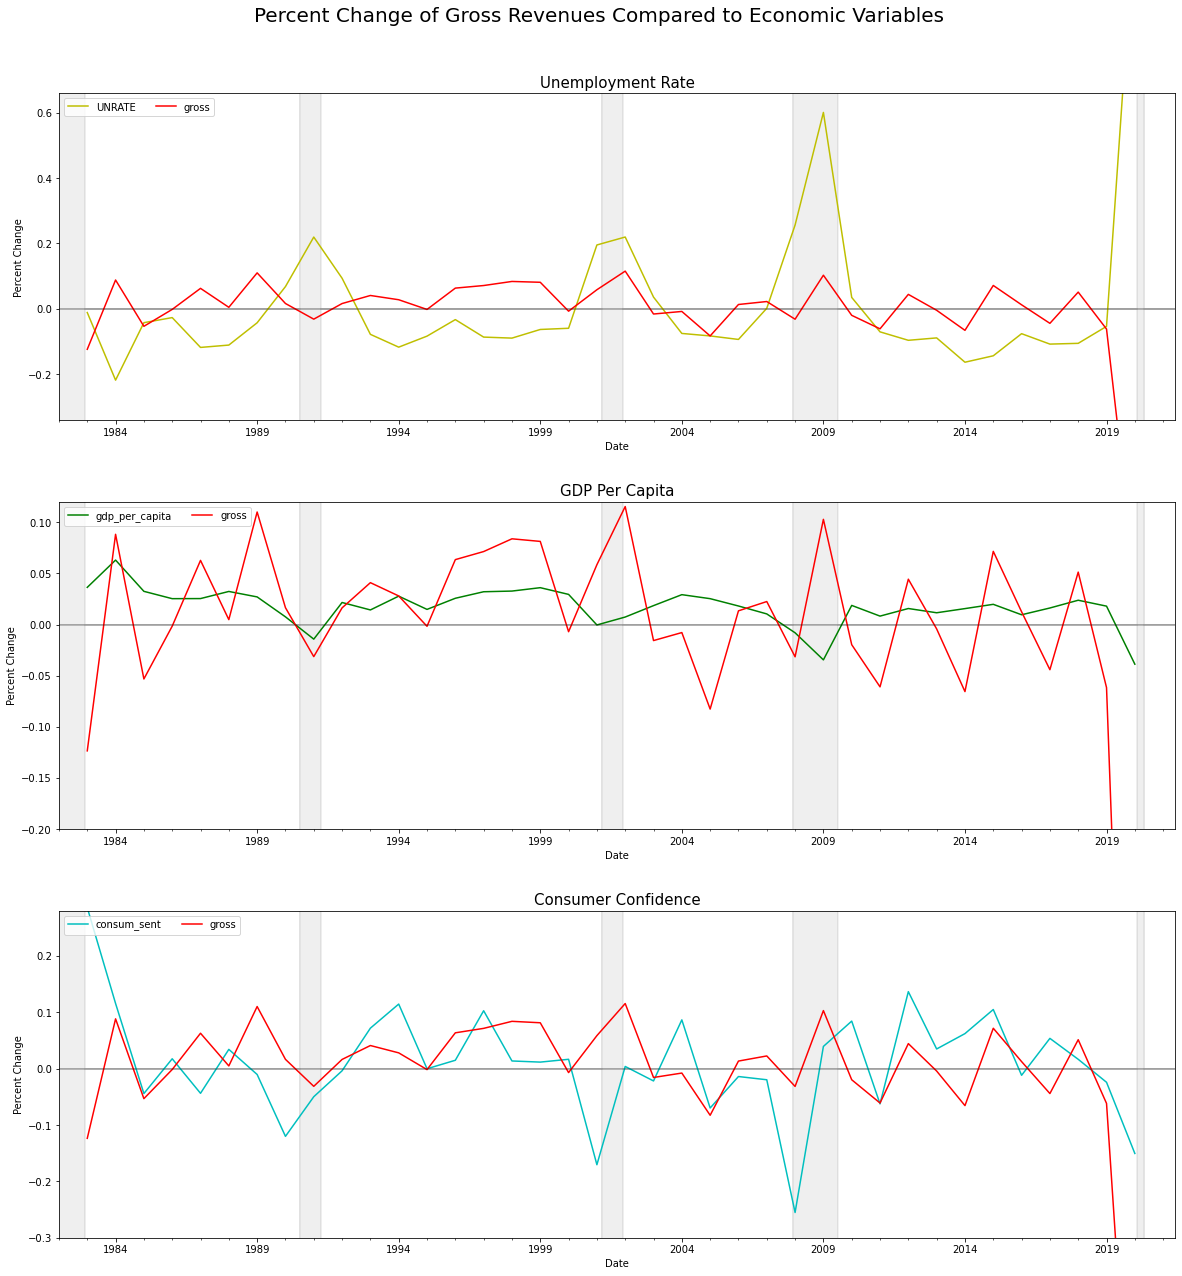

In [317]:
# Gross Revenues Compared to Economic Variables - Percent Changes

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Percent Change of Gross Revenues Compared to Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year_pct[['UNRATE', 'gross']].plot(ax=axs[0], color = ('y','r'))
axs[0].legend(loc='upper left', ncol=3, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(-0.34, 0.66)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year_pct[['gdp_per_capita', 'gross']].plot(ax=axs[1], color = ('g','r'))
axs[1].legend(loc='upper left', ncol=3, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(-0.2, 0.12)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year_pct[['consum_sent', 'gross']].plot(ax=axs[2], color = ('c','r'))
axs[2].legend(loc='upper left', ncol=3, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(-0.3, 0.28)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Confidence", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("Percent Change")
axs[1].set_ylabel("Percent Change")
axs[2].set_ylabel("Percent Change")


Description of patterns of curves during recessions

The percent rate change on gross revenues, that apperas in all three plots, had two positive changes after the first two recessions, and three negative changes after the Dotcom recession, GFC and during the 2020 recession. We can see the same pattern as in the annual gross revenue adjusted for inflation graph. 

1.   Percent change of unemployment rate and gross revenues: Unemployment rate has a countercyclical trend. Percent change of unemployment rate has a negative relationship with the percent change of gross revenues most of the times. Only during the Dotcom recession and the GFC they moved with a positive relationship.
2.   Percent change of GDP per capita rate and gross revenues: GDP per capita rate has a procyclical trend. The percent change of GDP per capita stays more constant over time with respect to the percent change of gross revenues.
3.   Percent change of consmer sentiment rate and gross revenues: Consumer sentiment has a procyclical trend. From the percent change graph, we can see that the variables move independent from each other over time.




### Genres

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


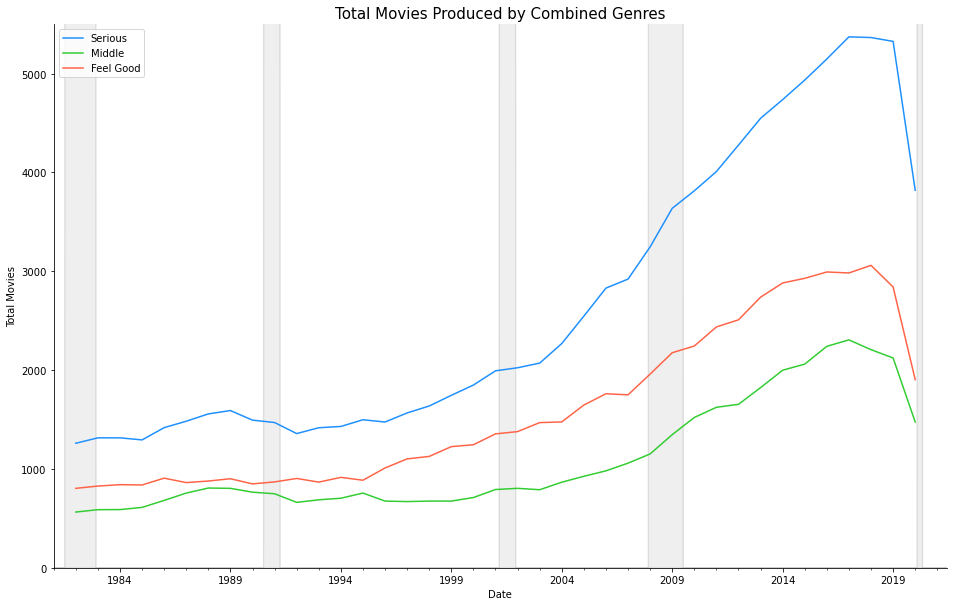

In [318]:
# Genres graphed by percent change
fig, ax = plt.subplots(figsize = (16,10))

us_rec_scale["USREC"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
genres[three_cats].plot(ax=ax, color=comb_cats_c)
ax.legend(loc='best')
ax.set_xlim("1981-01-01", "2021-06-01")
ax.set_ylim(0, 5500)

ax.set_title("Total Movies Produced by Combined Genres", fontsize=15)

for i in range(0,4):
    ax.set_ylabel("Total Movies")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


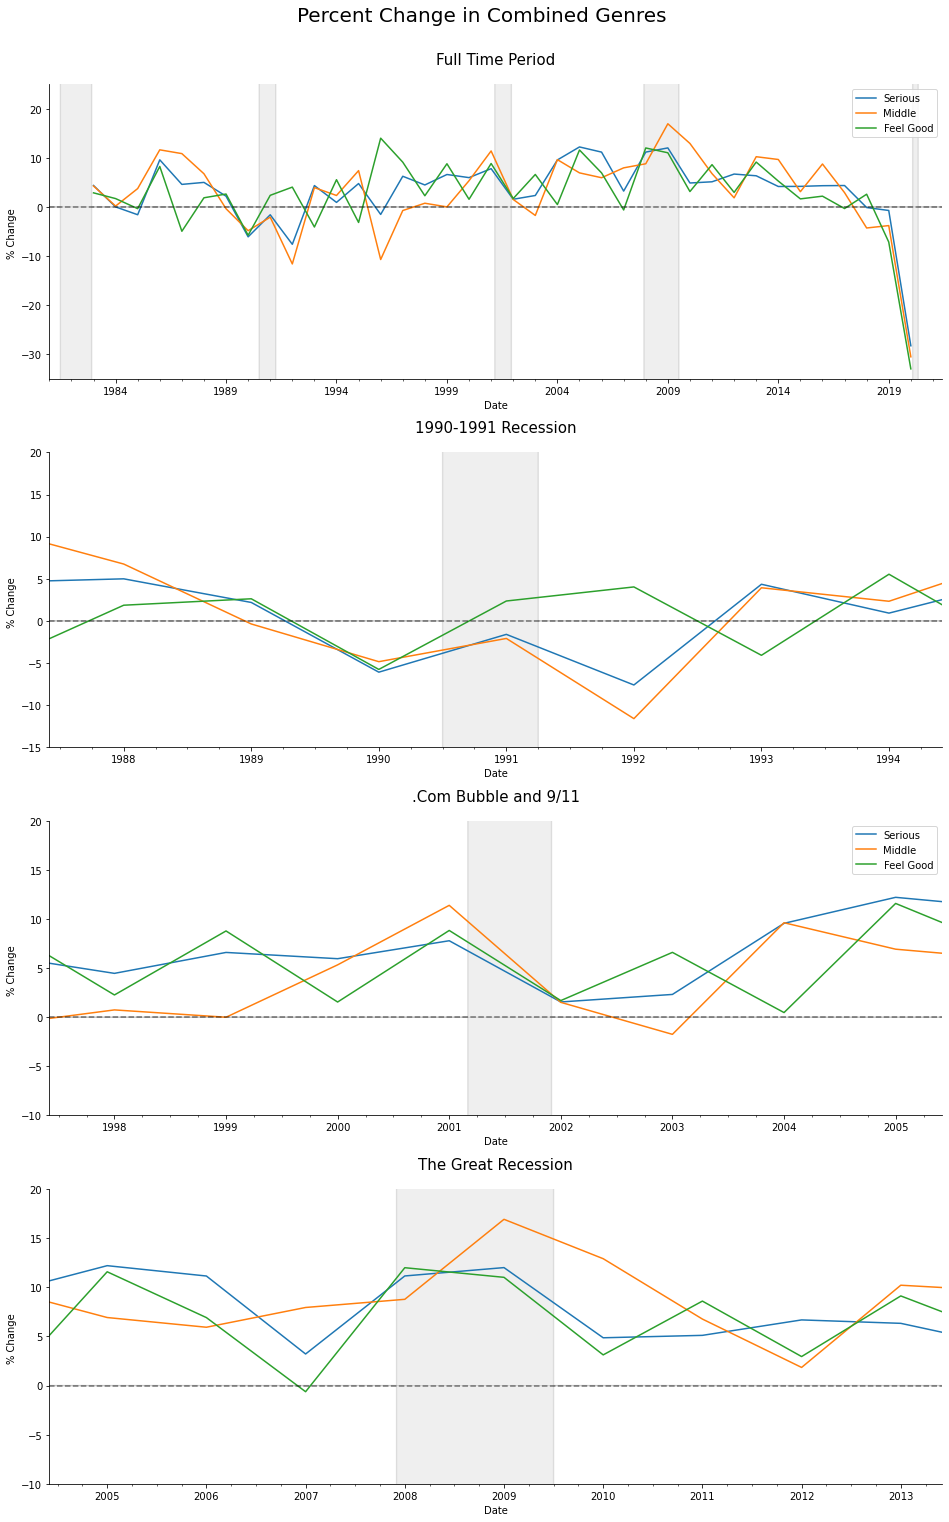

In [319]:
# Genres graphed by percent change
fig, axi = plt.subplots(4,1, figsize = (16,24))

us_rec_scale["USREC"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi[0])
axi[0].legend(loc='best')
axi[0].set_xlim("1981-01-01", "2021-06-01")
axi[0].set_ylim(-35, 25)

us_rec_scale["USREC"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi[1])
axi[1].get_legend().remove()
axi[1].set_xlim("1987-06-01", "1994-06-01")
axi[1].set_ylim(-15, 20)

us_rec_scale["USREC"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi[2])
axi[2].legend(loc='best')
axi[2].set_xlim("1997-06-01", "2005-06-01")
axi[2].set_ylim(-10, 20)

us_rec_scale["USREC"].plot.area(ax=axi[3], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[3], alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi[3])
axi[3].get_legend().remove()
axi[3].set_xlim("2004-06-01", "2013-06-01")
axi[3].set_ylim(-10, 20)


axi[0].set_title("Full Time Period", fontsize=15, pad=20)
axi[1].set_title("1990-1991 Recession", fontsize=15, pad=20)
axi[2].set_title(".Com Bubble and 9/11", fontsize=15, pad=20)
axi[3].set_title("The Great Recession", fontsize=15, pad=20)

fig.suptitle(
    "Percent Change in Combined Genres", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=.25)

for i in range(0,4):
    axi[i].axhline(0, color="k", alpha=0.5, linestyle="--")
    axi[i].set_ylabel("% Change ")
    axi[i].spines["right"].set_visible(False)
    axi[i].spines["top"].set_visible(False)

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


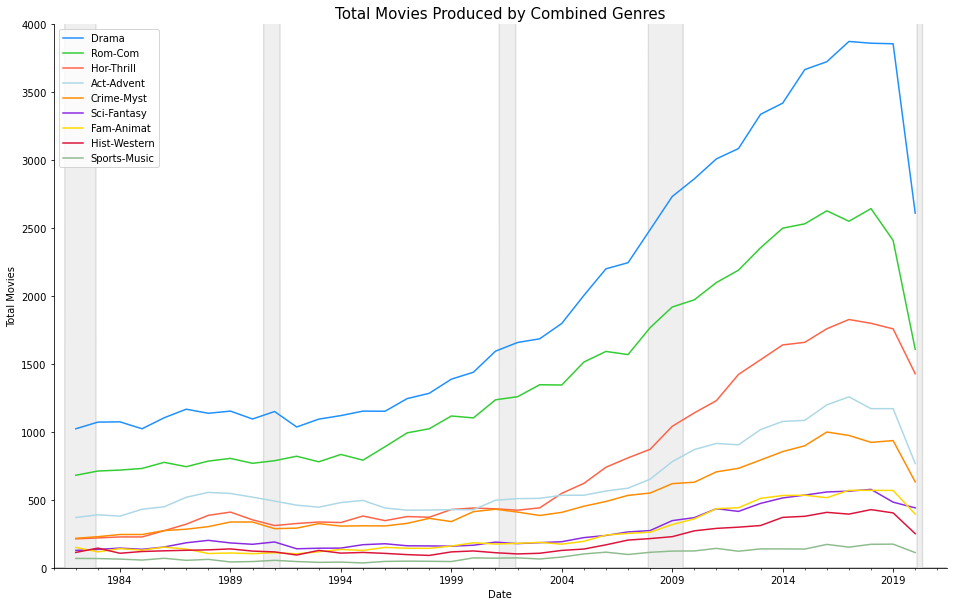

In [320]:
# Genres graphed by percent change
fig, ax = plt.subplots(figsize = (16,10))

us_rec_scale["USREC"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
genres[comb_cats].plot(ax=ax, color=comb_cats_c)
ax.legend(loc='best')
ax.set_xlim("1981-01-01", "2021-06-01")
ax.set_ylim(0, 4000)

ax.set_title("Total Movies Produced by Combined Genres", fontsize=15)

for i in range(0,4):
    ax.set_ylabel("Total Movies")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

In [321]:
import matplotlib.patches as mpatches

top3_cats = ["Drama", "Rom-Com", "Hor-Thrill"]
mid2_cats = ["Act-Advent", "Crime-Myst"]
smid2_cats = ["Fam-Animat","Sci-Fantasy"]
bot3_cats = ["Hist-Western", "Sports-Music"]

top3_cats_c = ["dodgerblue", "limegreen", "tomato"]
mid2_cats_c = ["lightblue", "darkorange"]
smid2_cats_c = ["blueviolet", "gold"] 
bot3_cats_c = ["crimson", "darkseagreen"]

In [322]:
patch_sport = mpatches.Patch(color="crimson", label ="Hist-Western")
patch_his = mpatches.Patch(color="darkseagreen", label ="Sports-Music")
patch_Dra = mpatches.Patch(color= "dodgerblue", label = "Drama")
patch_Rom = mpatches.Patch(color= "limegreen", label = "Rom-Com")
patch_Hor = mpatches.Patch(color= "tomato", label = "Hor-Thrill")
patch_Act = mpatches.Patch(color= "lightblue", label = "Act-Advent")
patch_Cri = mpatches.Patch(color= "darkorange", label = "Crime-Myst")
patch_Fam = mpatches.Patch(color= "blueviolet", label = "Fam-Animat")
patch_Sci = mpatches.Patch(color= "gold", label = "Sci-Fantasy")


/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


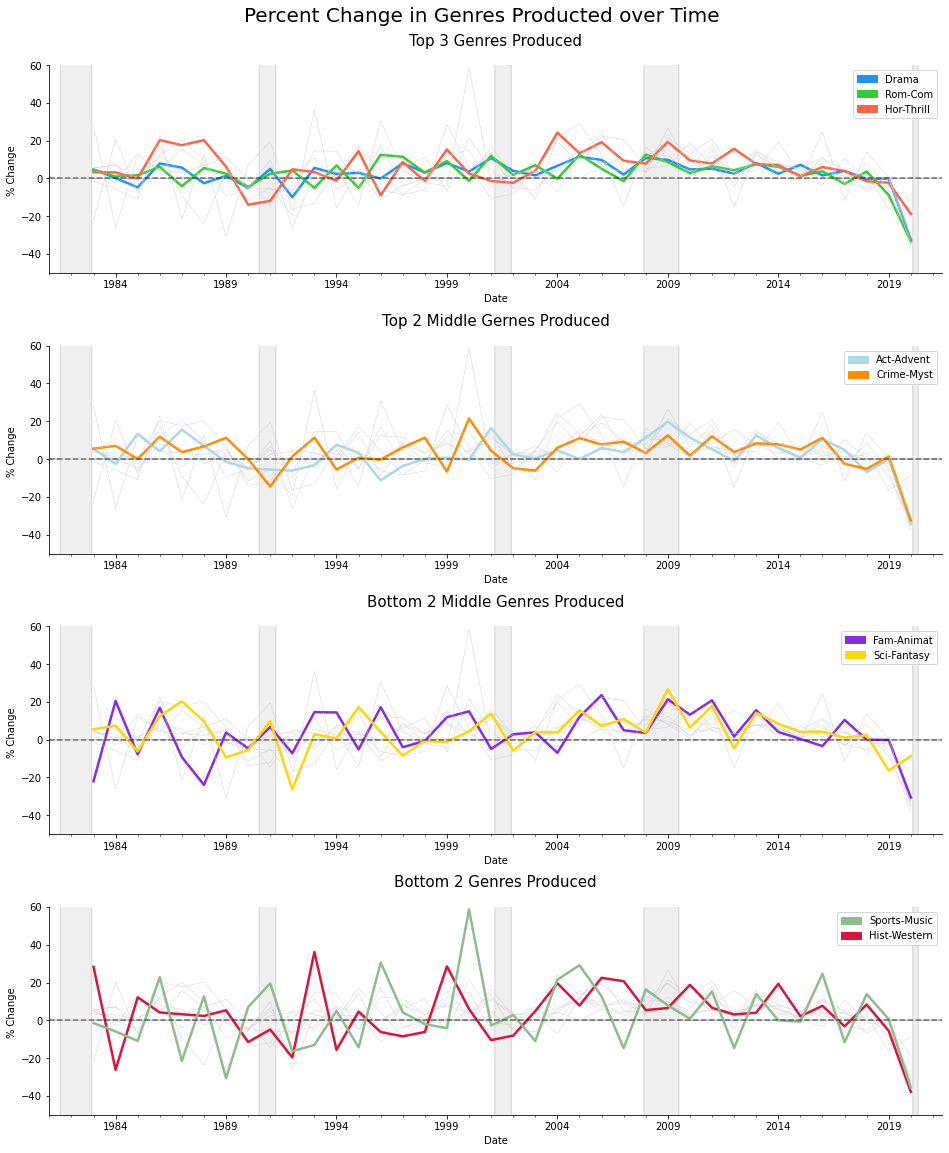

In [331]:
fig, ax = plt.subplots(4,1, figsize = (16,18))

us_rec_scale["USREC"].plot.area(ax=ax[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[0], alpha=0.12, color="gray", label=str())
genres_pct[top3_cats].plot(ax=ax[0], color = top3_cats_c, linewidth=2.5)
genres_pct[smid2_cats].plot(ax=ax[0], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[bot3_cats].plot(ax=ax[0], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[mid2_cats].plot(ax=ax[0], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
ax[0].legend(handles = [patch_Dra, patch_Rom, patch_Hor])
ax[0].set_xlim("1981-01-01", "2021-06-01")
ax[0].set_ylim(-50, 60)

us_rec_scale["USREC"].plot.area(ax=ax[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[1], alpha=0.12, color="gray", label=str())
genres_pct[top3_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[mid2_cats].plot(ax=ax[1], color = mid2_cats_c, linewidth=2.5)
genres_pct[smid2_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[bot3_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=[str(),str()])
ax[1].legend(handles = [patch_Act, patch_Cri])
ax[1].set_xlim("1981-01-01", "2021-06-01")
ax[1].set_ylim(-50, 60)

us_rec_scale["USREC"].plot.area(ax=ax[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[2], alpha=0.12, color="gray", label=str())
genres_pct[top3_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=False)
genres_pct[mid2_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=False)
genres_pct[smid2_cats].plot(ax=ax[2], color = smid2_cats_c, linewidth=2.5)
genres_pct[bot3_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
ax[2].legend(handles = [patch_Fam, patch_Sci])
ax[2].set_xlim("1981-01-01", "2021-06-01")
ax[2].set_ylim(-50, 60)


us_rec_scale["USREC"].plot.area(ax=ax[3], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[3], alpha=0.12, color="gray", label=str())
genres_pct[top3_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[mid2_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_pct[smid2_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label='_Hidden label')
genres_pct[bot3_cats].plot(ax=ax[3], color = bot3_cats_c, linewidth=2.5)
ax[3].legend(handles = [patch_his, patch_sport])
ax[3].set_xlim("1981-01-01", "2021-06-01")
ax[3].set_ylim(-50, 60)

ax[0].set_title("Top 3 Genres Produced", fontsize=15, pad=20)
ax[1].set_title("Top 2 Middle Gernes Produced", fontsize=15, pad=20)
ax[2].set_title("Bottom 2 Middle Genres Produced", fontsize=15, pad=20)
ax[3].set_title("Bottom 2 Genres Produced", fontsize=15, pad=20)

fig.suptitle(
    "Percent Change in Genres Producted over Time", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=.35)

for i in range(0,4):
    ax[i].axhline(0, color="k", alpha=0.5, linestyle="--")
    ax[i].set_ylabel("% Change ")
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)

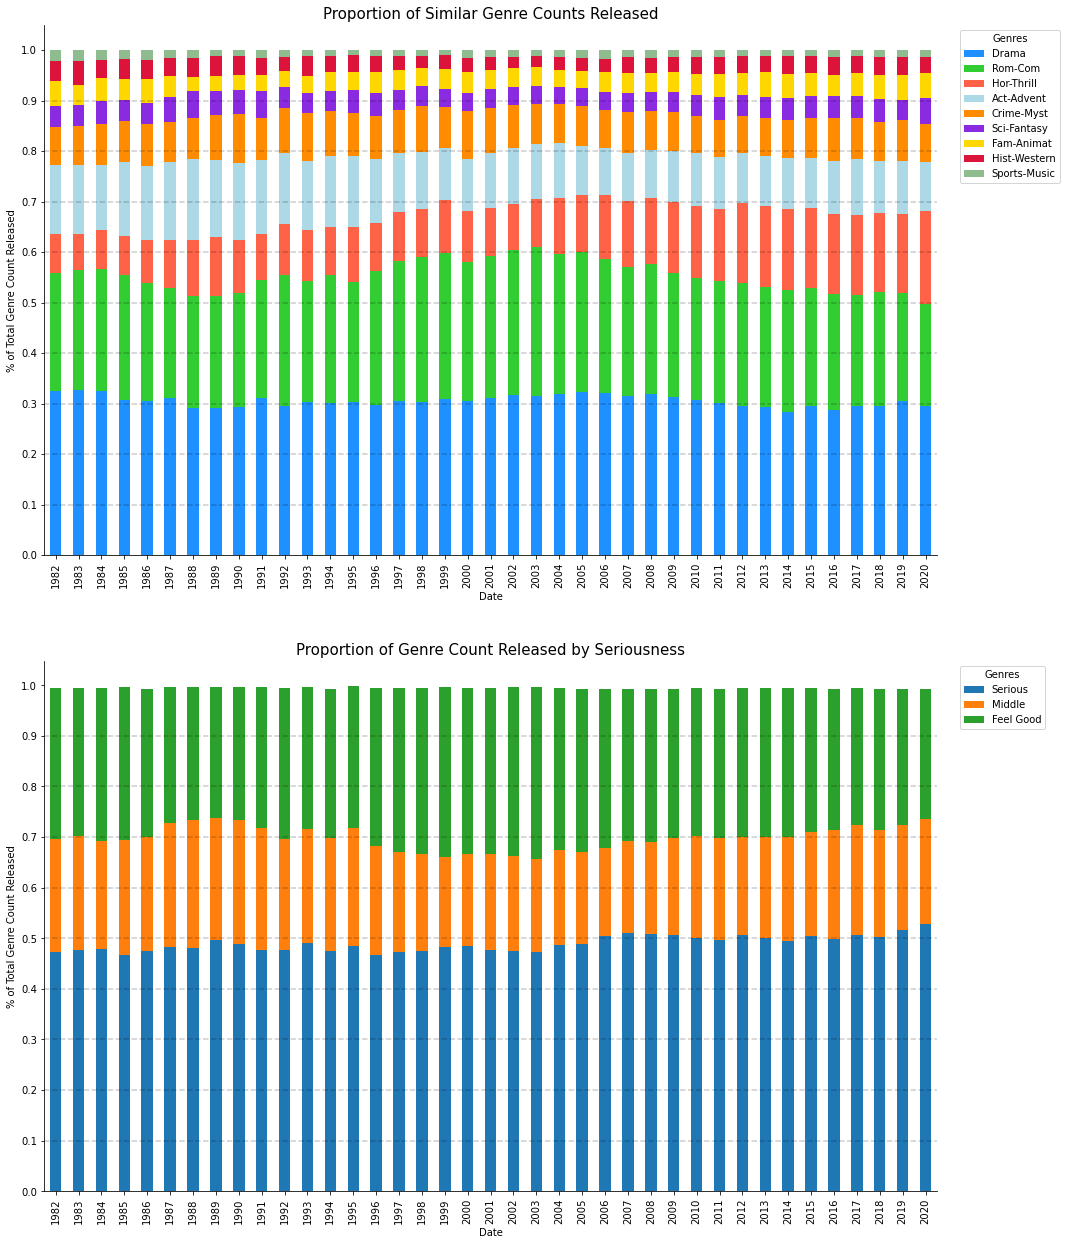

In [335]:

fig, ax = plt.subplots(2,1, figsize=(16,20))

genres_share[comb_cats].plot.bar(stacked=True, ax=ax[0], color = comb_cats_c)
ax[0].legend(title='Genres', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1)
ax[0].set_title("Proportion of Similar Genre Counts Released", fontsize=15)
ax[0].set_ylabel("% of Total Movies")
ax[0].set_xlabel("Date")

genres_share[three_cats].plot.bar(stacked=True, ax=ax[1], color=three_cats_c)
ax[1].legend(title='Genres', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1)
ax[1].set_title("Proportion of Genre Count Released by Seriousness", fontsize=15)
ax[1].set_ylabel("% of Total Movies")
ax[1].set_xlabel("Date")

for i in range(0,2):
    ax[i].set_ylabel("% of Total Genre Count Released")
    ax[i].set_xlabel("Date")
    ax[i].set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)

for i in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    ax[0].axhline(i, color="k", alpha=0.2, linestyle="--")
    ax[1].axhline(i, color="k", alpha=0.2, linestyle="--")


plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=None)

# Relationship between the supply and demand

These plots could explain the relationship between gross revenues and rerleases.

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


(-25.0, 25.0)

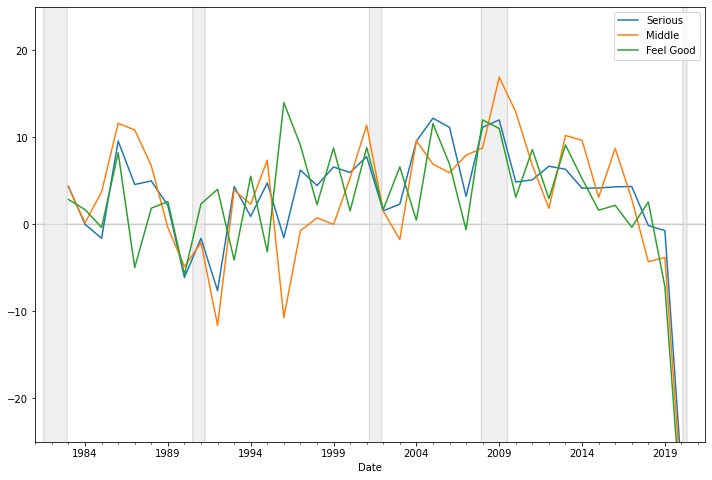

In [325]:
fig, axi = plt.subplots(figsize = (12,8))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi)
plt.legend(loc='best')
plt.xlim("1981-01-01", "2021-06-01")
plt.ylim(-25, 25)

### Economic variables and SUPPLY side of the film industry





Text(2009-01-01, 500, 'The Great Recession')

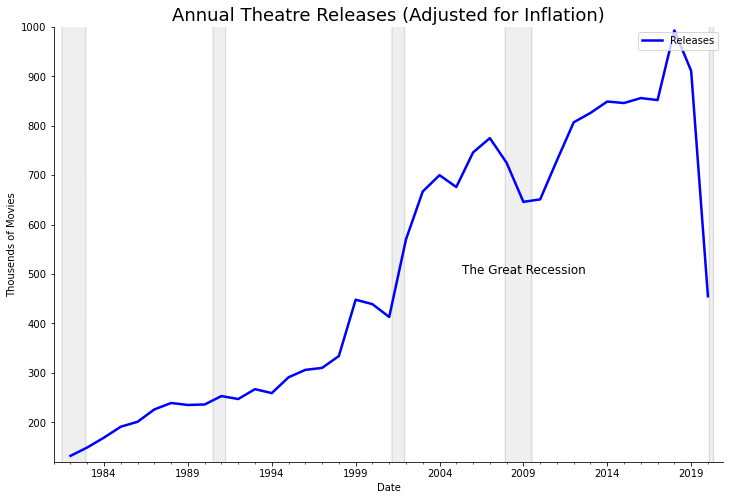

In [326]:
# Annual theater releases (adjusted for inflation)

fig, axi = plt.subplots(figsize=(12,8))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())

data_box_year['Releases'].plot(
    color = ('blue'), 
    ax=axi, 
    label="Releases",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper right')
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(120,1000)

axi.spines["right"].set_visible(False)
axi.spines["top"].set_visible(False)
axi.set_title(
    "Annual Theatre Releases (Adjusted for Inflation)",
    fontsize = 18)
axi.set_ylabel("Thousends of Movies")

axi.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 500),
    fontsize=12,
     horizontalalignment="center")

Description of curve during recession

1.   From 1981-08-01 to 1982-11-01: No apparent effect of recession on movie releases that increase exponentially starting at 110 in 1981.
2.   From 1990-08-01 to 1991-03-01: No apparent effect of recession on movie releases that increase exponentially reaching 420 in 1981.
3.   From 2001-04-01 to 2001-11-01: No apparent effect of recession on movie releases that increase exponentially reaching 730 in 2007.
4.   From 2008-01-01 to 2009-06-01: No apparent effect of recession on movie releases that increase exponentially reaching 1000 in 2018.
5.   From 2020-03-01 to 2020-04-01: Massive decrease in movie releases prios to the Covid recession. The values are equal to the movie releases in 2001 during the Dotcom recession.

Plots showing the economic variables and releases

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0, 0.5, 'Percent Change')

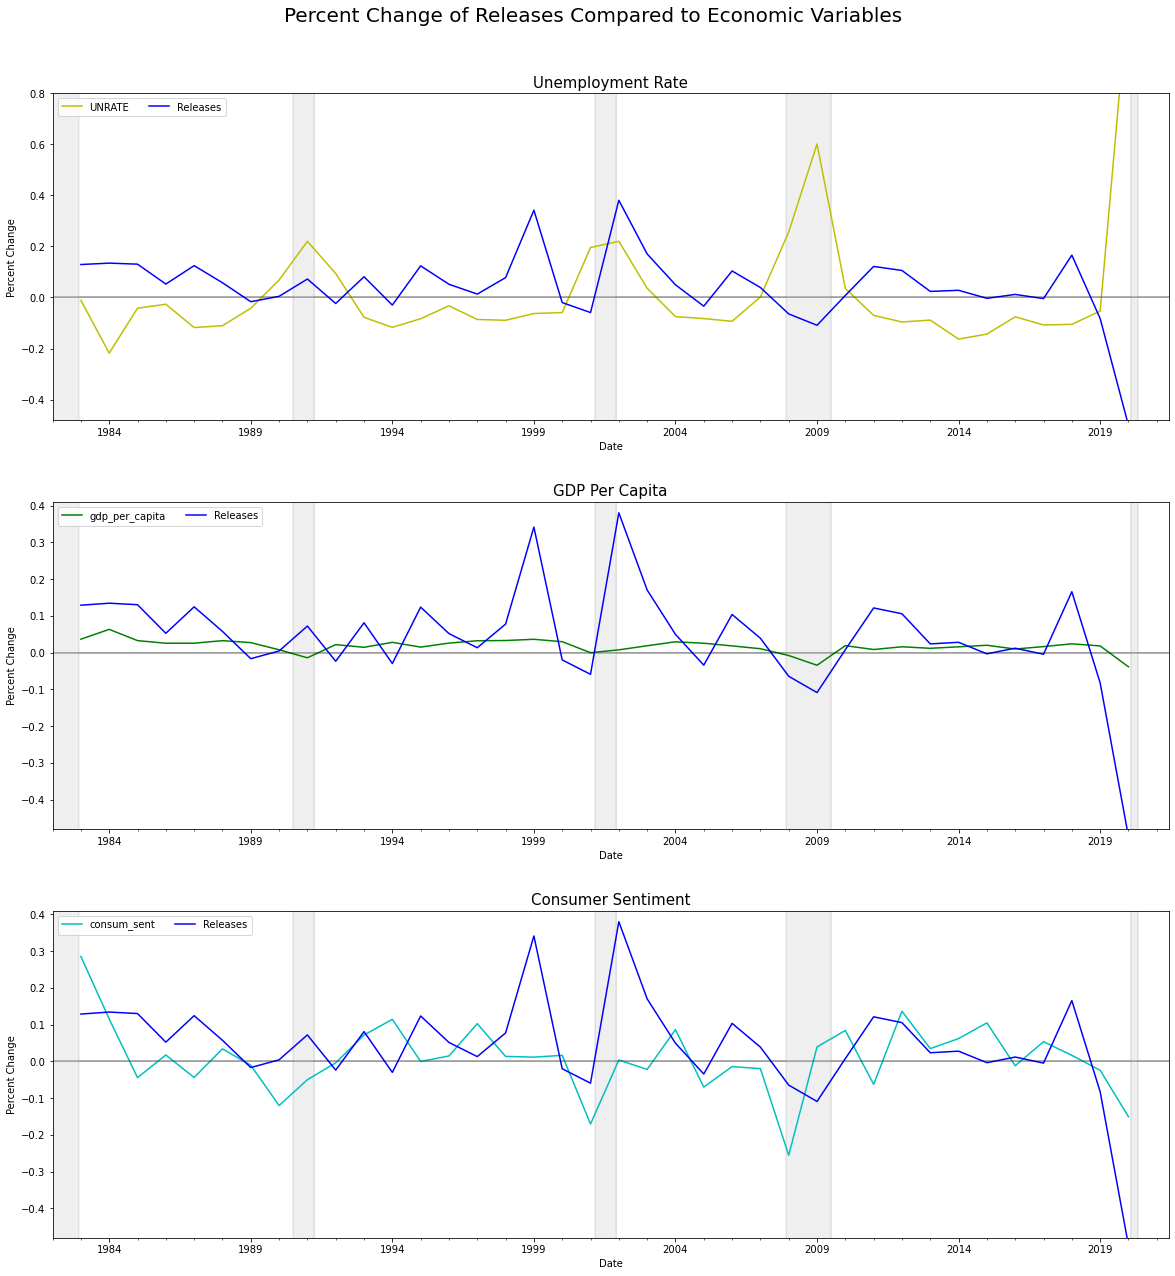

In [327]:
# Number of Releases Compared to Economic Variables - Percent Changes

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Percent Change of Releases Compared to Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year_pct[['UNRATE', 'Releases']].plot(ax=axs[0], color = ('y','b'))
axs[0].legend(loc='upper left', ncol=3, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(-0.48, 0.8)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year_pct[['gdp_per_capita', 'Releases']].plot(ax=axs[1], color = ('g','b'))
axs[1].legend(loc='upper left', ncol=3, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(-0.48, 0.41)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year_pct[['consum_sent', 'Releases']].plot(ax=axs[2], color = ('c','b'))
axs[2].legend(loc='upper left', ncol=3, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(-0.48, 0.41)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Sentiment", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("Percent Change")
axs[1].set_ylabel("Percent Change")
axs[2].set_ylabel("Percent Change")


Description of patterns of curves during recessions

The percent change on movie releases, that apperas in all three plots, reacted differently after all the five recessions. We can see that the largest percent changes of releases occured before, during, and after the Dotcom recession. 

1.   Percent change of unemployment rate and movie releases: Unemployment rate has a countercyclical trend. Percent change of unemployment rate has a negative relationship with the percent change of movie release most of the times. Only during the second and the Dotcom recession they moved with a positive relationship.
2.   Percent change of GDP per capita rate and movie releases: GDP per capita rate has a procyclical trend. The percent change of GDP per capita stays more constant over time with respect to the percent change of  movie release.
3.   Percent change of consmer sentiment rate and movie releases: Consumer sentiment has a procyclical trend. From the percent change graph we can see that the variables move independent from each other over time.




# Interpretation (to be cleaned)
-We find no effect of the economy on the genre mix of the supply of movies. However, There seems to be a connection between the GDP per capita and the overall supply measured in the number of films released. --> The number of films released is influenced by the number of films released in the preceding quarter (lag 1) and three quarters before (lag 3). 

-Supply is affected by economics varriables (UK). Supply affects economic variables (Germany).

-Demand is not affected by economic variables. Consistent with the studies referred to in the literature review. The change in GDP per capita does not affect respective revenue share of the three umbrella genres. Thus, the genre mix cannot be better explained using economic indicators and vice versa.

-The behavior is explained by the fact that going to the cinema is a cheap  leisure activity. This behaviour didn’t change until very recently when other factors came into play such as Netflix, etc.

-Film is regarded as art.

-No correlation between quality of the supply of movies and the demand of movies.

-The economic and quality indicators cannot sufficiently explain the shifts in genre structure of movie supply and demand.

-If the economic and quality indicators cannot sufficiently explain the shifts in the genre structure of movie supply and demand, and demand only partly instructs supply, other influencing factors might be more powerful explicators. We follow the approach of Gowgiel and Mcintosh (2010) who suggest that different types of threats might have different effects on TV viewing habits. They use the attacks on the World Trade Center as an example of a physical threat and the collapse of the Lehman Brothers bank as example of an economic threat. While the former would lead to a higher demand for serious content, the latter would have no effect on viewing habits. Overall demand in our sample is fluctuating too much to render an impact-response-analysis a viable analytic strategy. Thus, in the following we will provide a visual inspection of the data and focus on changes in the genre shares in the aftermath of the same events analyzed by Gowgiel and Mcintosh. 

-We can conclude that on the supply side, the distributors show a more pronounced reaction on external event than the audience on the demand side. This supports the view of distributors not only reacting on the demand but reacting based on a sense oof a mission.

# Conclusion (to be cleaned)

-The demand for cinema entertainment as a whole is unrelated to economic indicators such as GDP, consumer sentiment, and unemployment rate. Only the GDP per capita has some effect on the overall demand. In the US, a cinema visit can be considered as a low-cost leisure activity. 

-We could possibly find different results for markets in which a cinema visit is more expensive relative to purchasing power. However, we find no connection between income and genre choice. We have contradictory results concerning the interaction between economy and movie supply. The results might be improved if we could add information about the average production budget to the number of films released. The number of films released is less likely to change with the GDP than the budget since the number of screens and the release slots remain on the same level while the production funds might dry up during a recession. 

-However, it is evident from our results that many distributors are not predominantly in the market for profit maximization since they constantly release more serious movies than are in demand. Distributors seem to be willing to adjust their movie portfolios to economic and societal changes, but they do not seem to be especially good at anticipating shifts in audience interest.

-Last recession showed a negative correlation between releases and GDP per capita. Given that recession, was very small, we cannot say that the decrease in movie releases was due to the recession but due to other factors in the economy such as covid and other technology improvements.

-Thus, we continue to say that the film industry is still recession proof.

-The fluctuation of the quality of the movie in any given time period is higher than the fluctuation of consumer demand induced by economic growth of recession.

-The Covid recession period was different than any other recession period in the history. Histotical events since 2017 affected significantly the film industry. Then, the pandemic made the situation worse. We cannot say that Covid recession influenced dirrectly the film industry--> Film industry is recession proof.
